In [4]:
!pip install delta-sharing

In [5]:
import delta_sharing

# Point to the profile file. It can be a file on the local file system or a file on a remote storage.
profile_file = "/content/config.share"


In [6]:
# Create a SharingClient.
client = delta_sharing.SharingClient(profile_file)

In [7]:
# List all shared tables.
client.list_all_tables()

[Table(name='amazon_reviews', share='share__products', schema='bronze'),
 Table(name='sample_amazon_metadata', share='share__products', schema='bronze'),
 Table(name='sample_amazon_reviews', share='share__products', schema='bronze')]

In [8]:
# Create a url to access a shared table.
# A table path is the profile file path following with `#` and the fully qualified name of a table
# (`<share-name>.<schema-name>.<table-name>`).
table_url = profile_file + "#share__products.bronze.sample_amazon_reviews"

In [9]:
# Fetch 10 rows from a table and convert it to a Pandas DataFrame. This can be used to read sample data
# from a table that cannot fit in the memory.
# delta_sharing.load_as_pandas(table_url, limit=10)

# Load a table as a Pandas DataFrame. This can be used to process tables that can fit in the memory.
# delta_sharing.load_as_pandas(table_url)

# If the code is running with PySpark, you can use `load_as_spark` to load the table as a Spark DataFrame.
# delta_sharing.load_as_spark(table_url)


In [10]:
table_url

'/content/config.share#share__products.bronze.sample_amazon_reviews'

# EDA

### Preguntas
- Las imagenes existen?
- Como podemos analizar que una review sea verificada. Son mas importantes?
-  Existen productos puntuados pero sin reseñas.
- Existe una forma de ver el producto?: Seria interesante poder visualizar el producto que se quiere mejorar.
- *unixReviewTime*: Este tiempo es para la verificación de la review? y este tiempo en que unidades es.

## Primera revisión

La mayoría de imagenes no se encuentra, las imagenes son una url. Seria bueno revisar la metadata para ver si podemos optener las imagenes de los productos. Adicional mente, hay reviews vacios donde solo se tienen las puntuaciones. Sobre *unixReviewTime*, si es el tiempo de verificación, seria bueno saber cuanto es el costo de cuanto demora esa revisión.

In [88]:
data = delta_sharing.load_as_pandas(table_url)
data.head()

,asin,image,overall,reviewText,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,B00LQM3O36,None,1.0,Very disappointed. Was ordered as a gift for ...,A2YAZXQWIKO8I9,Rebecca Strozier,"{""Size:"":"" One Size"",""Color:"":"" Elsa Dress""}",Very disappointed. Was ordered as a gift for m...,1411948800,false,None
1,0465036376,None,4.0,Jaspin should be commended for telling the sto...,A1GSEIT3BP2RLO,Dr. Toby Ziglar,"{""Format:"":"" Hardcover""}",Uncovering Hidden Treasures,1176163200,false,17
2,B00LQM3O36,None,3.0,Disappointed with the quality.,A3L4FSHH3BURY6,Carole P.,"{""Size:"":"" One Size"",""Color:"":"" Elsa Dress""}",Three Stars,1411948800,true,None
3,0465032982,None,5.0,"Excellent book, a must have additon to any cou...",A17D757Q0VL4SF,Sunbunny064,"{""Format:"":"" Kindle Edition""}",Excellent,1364688000,true,None
4,B00LQM3O36,None,3.0,Disappointed with the quality.,A3L4FSHH3BURY6,Carole P.,"{""Size:"":"" One Size"",""Color:"":"" Anna Dress""}",Three Stars,1411948800,true,None


<Axes: >

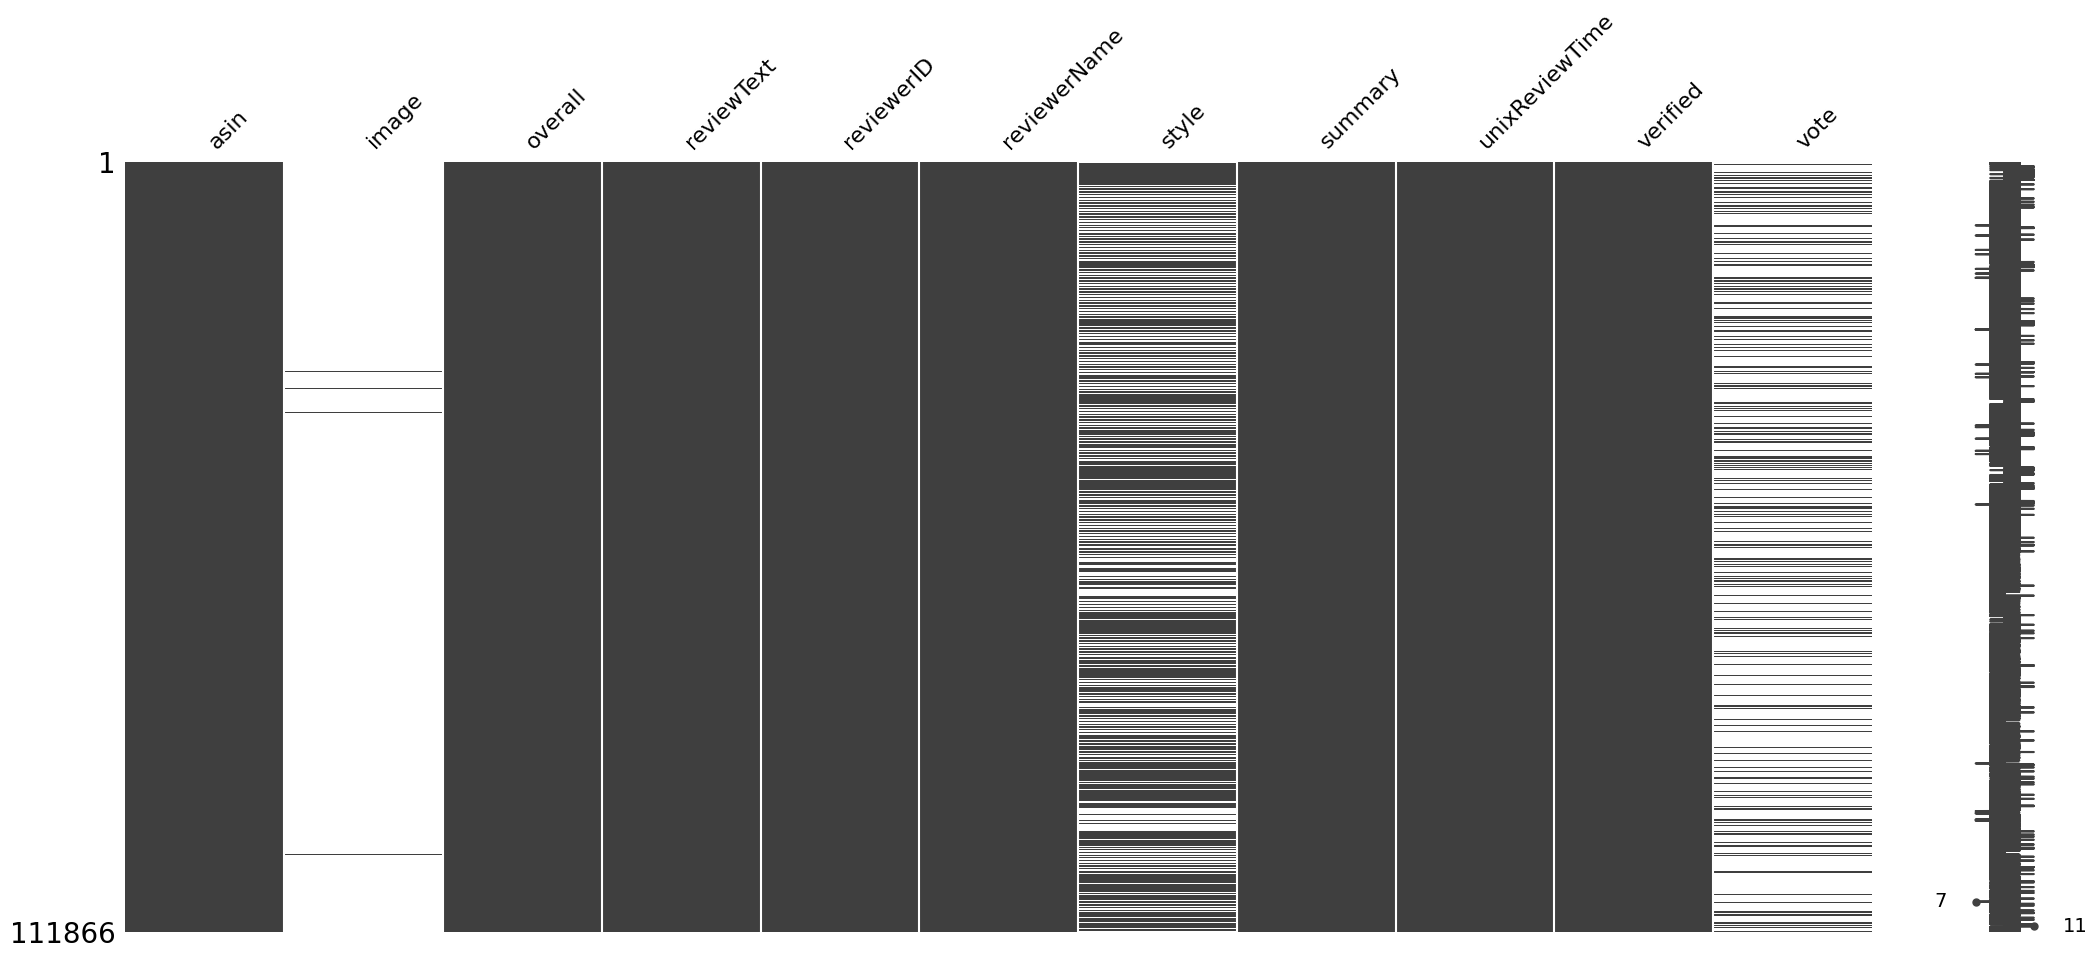

In [12]:
import missingno as msno

msno.matrix(data)

In [13]:
data.isnull().sum()

asin                   0
image             110978
overall                0
reviewText            51
reviewerID             0
reviewerName           3
style              42797
summary               15
unixReviewTime         0
verified               0
vote               83787
dtype: int64

In [14]:
data[data["reviewText"].isnull()].head()

,asin,image,overall,reviewText,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
21,0465032982,None,5.0,None,AE1G1AUUUZPKD,Robert D Schales,"{""Format:"":"" Hardcover""}",Five Stars,1359072000,false,None
886,B00LQXHBAC,None,4.0,None,A1BNU92K69LUMC,valone,"{""Product Packaging:"":"" Frustration-Free Packa...",Four Stars,1471305600,true,None
9115,0465048978,None,5.0,None,A1FWTOFELS4P0Q,Gloria Lynaugh,"{""Format:"":"" Hardcover""}",Five Stars,1457222400,true,None
9208,B00LU2VCBS,None,5.0,None,A3E9V7LW7JNZMM,Jose salinas,None,nice,1425859200,true,None
10680,B00LUHPJTO,None,5.0,None,A2ES10RRB7I6VV,Jen9,None,Five Stars,1419984000,true,None


Un "timestamp" es una forma de representar una fecha y hora en la computadora como un número entero, contando los segundos transcurridos desde una fecha de referencia. En este caso, el timestamp 1411948800 representa el número de segundos que han transcurrido desde el 1 de enero de 1970, que es una fecha de referencia comúnmente utilizada en sistemas operativos y lenguajes de programación, y se le conoce como el "Unix Epoch time".

In [90]:
data["unixReviewTime"][0]

'1411948800'

In [143]:
import datetime

def timestamp_to_date(timestamp):
    try:
        # Convertir el timestamp a un objeto datetime
        dt_object = datetime.datetime.fromtimestamp(timestamp)

        # Obtener la fecha y hora legible
        formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')
        return formatted_date
    except Exception as e:
        return f"Error al convertir el timestamp: {e}"

# Ejemplo de uso
for i in range(100):
  timestamp = int(data["unixReviewTime"][i])
  fecha_legible = timestamp_to_date(timestamp)
  print(f"Fecha legible: {fecha_legible}")


KeyError: ignored

In [15]:
data["image"][42266]

'["https://images-na.ssl-images-amazon.com/images/I/71fh7+PWn7L._SY88.jpg","https://images-na.ssl-images-amazon.com/images/I/61yaJNfw8ZL._SY88.jpg","https://images-na.ssl-images-amazon.com/images/I/61Dh6H0dY8L._SY88.jpg"]'

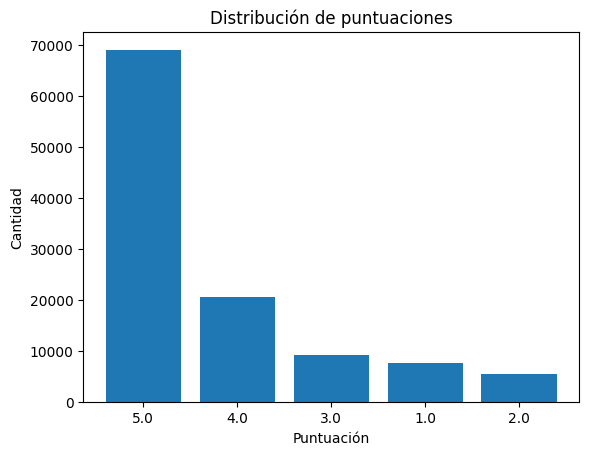

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
conteo_puntuaciones =  data['overall'].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad')
plt.title('Distribución de puntuaciones')
plt.xticks(conteo_puntuaciones.index)
plt.show()

Quiero ver si la verificación agrega alguna particularidad que podamos usar.

## Explorando la verificación True

In [ ]:
# Filtrar las filas donde 'verified' es igual a True
data_vtrue =  data[data['verified'] == "true"]
data_vtrue


Con el style podemos saber un poco mas sobre el producto. Por ejemplo hay Elsa Dress, Kindle Edition, Hardcover que probablemente sea un libro.

In [84]:
data_vtrue["style"].head(30)

2     {"Size:":" One Size","Color:":" Elsa Dress"}
3                    {"Format:":" Kindle Edition"}
4     {"Size:":" One Size","Color:":" Anna Dress"}
5                         {"Format:":" Hardcover"}
6     {"Size:":" One Size","Color:":" Elsa Dress"}
7                         {"Format:":" Hardcover"}
9                    {"Format:":" Kindle Edition"}
11                        {"Format:":" Hardcover"}
13                        {"Format:":" Hardcover"}
15                        {"Format:":" Hardcover"}
16    {"Size:":" One Size","Color:":" Anna Dress"}
17                        {"Format:":" Hardcover"}
19                        {"Format:":" Hardcover"}
22    {"Size:":" One Size","Color:":" Anna Dress"}
24    {"Size:":" One Size","Color:":" Elsa Dress"}
28    {"Size:":" One Size","Color:":" Elsa Dress"}
38    {"Size:":" One Size","Color:":" Anna Dress"}
43                        {"Format:":" Paperback"}
44    {"Size:":" One Size","Color:":" Elsa Dress"}
48    {"Size:":" One Size","Col

Veamos algunas reseñas que tienen verificación.

In [79]:
[ str(i)+" Vote:" + str(data_vtrue["vote"][i]) +" " + data_vtrue["reviewText"][i]+" OVERALL: "+data_vtrue["overall"][i] for i in list(data_vtrue.index)[:80]]

['2 Vote:None Disappointed with the quality. OVERALL: 3.0',
 "3 Vote:None Excellent book, a must have additon to any counseling student's library. The book is set up in an easy to follow format, and the authors message is easy to understand. I have the kindle version and I love it. OVERALL: 5.0",
 '4 Vote:None Disappointed with the quality. OVERALL: 3.0',
 '5 Vote:None This book is well written and is the guru of the Group psychotherapy. You will sure get a lot of infomation from this. OVERALL: 4.0',
 '6 Vote:None My granddaughter was so excited when you opened her pkg. great gift affordable price OVERALL: 5.0',
 '7 Vote:None Anyone wanting to open up their mind in Psychotherapy this is the book that will do just that for you. OVERALL: 4.0',
 '9 Vote:None We used this textbook in my group therapy class and it is fabulous! Yalom is a great writer with so many gems to share and this book is full of gems. I would suggest it to anyone. OVERALL: 5.0',
 "11 Vote:None It's Yalom!  Of course i

Seria bueno un modelo de filtrado para conocer la intención de las reseñas, para así poder ver cuales son las que nos pueden ser utiles para mejorar el negocio.

La reseñas algunas son elogiando el producto, otras son quejas muy especificas sobre daños del producto, lo cual me parece muy util.

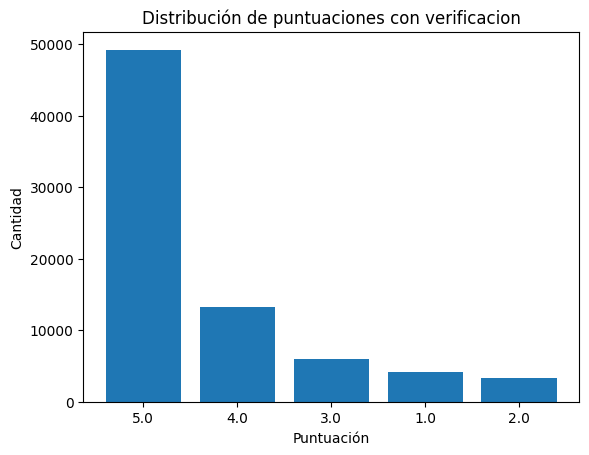

In [97]:
conteo_puntuaciones =  data_vtrue['overall'].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad')
plt.title('Distribución de puntuaciones con verificacion')
plt.xticks(conteo_puntuaciones.index)
plt.show()

## Explorando la verificacion False

In [ ]:
# Filtrar las filas donde 'verified' es igual a True
data_vfalse =  data[data['verified'] == "false"]
data_vfalse


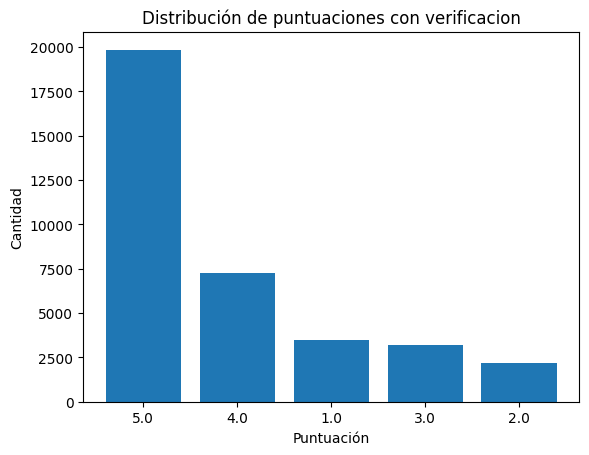

In [98]:
conteo_puntuaciones =  data_vfalse['overall'].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad')
plt.title('Distribución de puntuaciones con verificacion')
plt.xticks(conteo_puntuaciones.index)
plt.show()

In [100]:
[ str(i)+" Vote:" + str(data_vfalse["vote"][i]) +" " + str(data_vfalse["reviewText"][i])+" OVERALL: "+str(data_vfalse["overall"][i]) for i in list(data_vfalse.index)[:80]]

["0 Vote:None Very disappointed.  Was ordered as a gift for my daughter.  She was thrilled for about an hour then her delight turned to sobbing!  I had already sewed all the snaps back on the dress (yes, in that first hour) and then low and behold the sleeve ripped.  No kidding, less than an hour of play and she can't play with it anymore.  Do NOT purchase!!!! OVERALL: 1.0",
 '1 Vote:17 Jaspin should be commended for telling the stories of these towns, even when the information concerning these incidents is scant.  Buried in the Bitter Waters serves as a reminder to its readers that racial cleansing in America took place throughout the country, not just the Deep South.  It also reminds us that much of the history of our country has yet to be told.  Selma, Birmingham, Memphis, and Montgomery are familiar names in the history of race in America.  Jaspin shines the light on towns like Corbin and Commanche, not to disparage them but to remind us that the racial clensing in America was wide

No veo ninguna particularidad que diferencia una review verificada y una que no. De hecho, se me hace muy confuso que significa que sea verificada ya que hay unas que son elogios y son verificados. Pensaría que tendría mucho mas sentido si verificara alguna error o algo así. Aunque ahora que lo pienso, puede referirse a la verificación de usuario y eso le daría cierto tipo de confiabilidad pero aún no veo claro si sea muy util esto del verificado.

Al final la verificación no creo que sea algo totalmente sustancial para ayudar la calidad de la ventas, de hecho, que sea verificado o no, no agrega mucho cambio o particularidad.

# Exploremos algunos productos

In [101]:
data

,asin,image,overall,reviewText,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,B00LQM3O36,None,1.0,Very disappointed. Was ordered as a gift for ...,A2YAZXQWIKO8I9,Rebecca Strozier,"{""Size:"":"" One Size"",""Color:"":"" Elsa Dress""}",Very disappointed. Was ordered as a gift for m...,1411948800,false,None
1,0465036376,None,4.0,Jaspin should be commended for telling the sto...,A1GSEIT3BP2RLO,Dr. Toby Ziglar,"{""Format:"":"" Hardcover""}",Uncovering Hidden Treasures,1176163200,false,17
2,B00LQM3O36,None,3.0,Disappointed with the quality.,A3L4FSHH3BURY6,Carole P.,"{""Size:"":"" One Size"",""Color:"":"" Elsa Dress""}",Three Stars,1411948800,true,None
3,0465032982,None,5.0,"Excellent book, a must have additon to any cou...",A17D757Q0VL4SF,Sunbunny064,"{""Format:"":"" Kindle Edition""}",Excellent,1364688000,true,None
4,B00LQM3O36,None,3.0,Disappointed with the quality.,A3L4FSHH3BURY6,Carole P.,"{""Size:"":"" One Size"",""Color:"":"" Anna Dress""}",Three Stars,1411948800,true,None
...,...,...,...,...,...,...,...,...,...,...,...
111861,B00006DY3F,None,5.0,This is a great and the service I received was...,A2V0H3SXFNASTS,Santos m.,None,Great game!,1357171200,true,None
111862,B000N8Q4JA,None,5.0,These are heavy weight pants that sit a little...,A1CAMD086N6AHG,Dan W. Mckay,"{""Size:"":"" 33W x 32L"",""Color:"":"" Brown Duck""}",Tough pants that fit just like the last pair.,1400716800,true,None
111863,B00006DY3F,None,1.0,"Avoid this dog-pile... Look, lots of people li...",A33NPMRZ42D6XC,E. Young,None,"Robo-TRASH: ""Make YOU Cry"" if you buy it!",1149379200,false,None
111864,B000N8Q4JA,None,5.0,my husband is a carpenter and very hard on his...,ADSRU5G5CWJ56,pat,"{""Size:"":"" 34W x 32L"",""Color:"":"" Brown""}",work pants,1400716800,true,None


Hay 111866 filas, pero en total hay 2024 productos. Eso quiere decir que hay varios productos que compran seguido.

In [102]:
data['asin'].value_counts()

B000MXQ2CU    5475
B000MXIMKK    3452
B000N3Q6S4    3218
B000N8Q4JA    2388
B000N3Q7B0    2109
              ... 
B0000691KL       1
B0000695HP       1
B000069111       1
B00LWHWCWE       1
B00M0HO01G       1
Name: asin, Length: 2024, dtype: int64

In [105]:
# Filtremos un producto
p1 =  data[data['asin'] == "B000MXQ2CU"]
p1

,asin,image,overall,reviewText,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
55964,B000MXQ2CU,None,5.0,Nice light weight pants,AIP8P6D32Y8XR,Ed Ferrante,"{""Size:"":"" 38W x 34L"",""Color:"":"" Graphite""}",Pant to fit,1504396800,true,None
55966,B000MXQ2CU,None,4.0,A little snug at the insean,A3MDQ51VINIHY5,Jerry Craft,"{""Size:"":"" 36W x 31L"",""Color:"":"" Heather Brown""}",Four Stars,1504310400,true,None
55968,B000MXQ2CU,None,3.0,The buttonhole is too small for the size button.,A2DNQH1QBXOBUZ,Linwood J. Martin,"{""Size:"":"" 42W x 29L"",""Color:"":"" String Beige""}",Three Stars,1504310400,true,None
55970,B000MXQ2CU,None,5.0,"Husband loves these for work, durable and wrin...",A294HHEQ702W2M,Zak and Lisette Longo,"{""Size:"":"" 40W x 30L"",""Color:"":"" Black""}",Five Stars,1504224000,true,None
55972,B000MXQ2CU,None,5.0,Great fit. Nice fabric.,A2JWTDSTLPO3BH,Marc,"{""Size:"":"" 36W x 32L"",""Color:"":"" Black""}",Easy way to buy pants.,1504224000,true,None
...,...,...,...,...,...,...,...,...,...,...,...
78236,B000MXQ2CU,None,4.0,I purchased these pants for the second time be...,A3FCBRV6V3MD9S,Robobear,"{""Size:"":"" 34W x 30L"",""Color:"":"" Navy""}",Comfortable and stylish,1313107200,true,6
78238,B000MXQ2CU,None,5.0,I must have tried at least 10 brands of pants ...,ATOIFXA9VFMRQ,S2cem,"{""Size:"":"" 32W x 32L"",""Color:"":"" Black""}",Great PANTS!!!,1313107200,true,None
78240,B000MXQ2CU,None,5.0,"These pants are, by far, one of the best pants...",ASQ7ECXSKRP94,Michael S,None,Professional looking pants for the hot and hum...,1309305600,true,115
78242,B000MXQ2CU,None,5.0,these pants are nice because they are stain re...,A16W8UCM99HLEU,Kris,None,best for work and golf!!,1305072000,false,84


In [107]:
p1["style"]

55964         {"Size:":" 38W x 34L","Color:":" Graphite"}
55966    {"Size:":" 36W x 31L","Color:":" Heather Brown"}
55968     {"Size:":" 42W x 29L","Color:":" String Beige"}
55970            {"Size:":" 40W x 30L","Color:":" Black"}
55972            {"Size:":" 36W x 32L","Color:":" Black"}
                               ...                       
78236             {"Size:":" 34W x 30L","Color:":" Navy"}
78238            {"Size:":" 32W x 32L","Color:":" Black"}
78240                                                None
78242                                                None
78244     {"Size:":" 44W x 30L","Color:":" Heather Blue"}
Name: style, Length: 5475, dtype: object

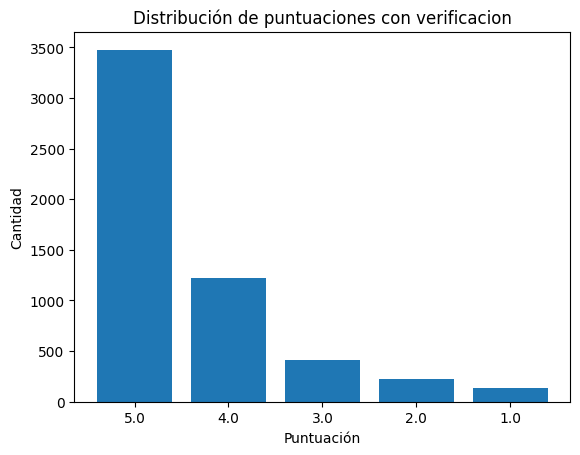

In [106]:
conteo_puntuaciones =  p1['overall'].value_counts()

plt.bar(conteo_puntuaciones.index, conteo_puntuaciones.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad')
plt.title('Distribución de puntuaciones con verificacion')
plt.xticks(conteo_puntuaciones.index)
plt.show()

In [ ]:
list(p1.index)


In [151]:
import datetime

def timestamp_to_date(timestamp):
    try:
        # Convertir el timestamp a un objeto datetime
        dt_object = datetime.datetime.fromtimestamp(timestamp)

        # Obtener la fecha y hora legible
        formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')
        return formatted_date
    except Exception as e:
        return f"Error al convertir el timestamp: {e}"

# Ejemplo de uso
for i in (list(p1.index)):
  timestamp = int(p1["unixReviewTime"][i])
  fecha_legible = timestamp_to_date(timestamp)
  print(f"Fecha legible: {fecha_legible}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Fecha legible: 2017-04-19 00:00:00
Fecha legible: 2017-04-19 00:00:00
Fecha legible: 2017-04-19 00:00:00
Fecha legible: 2017-04-19 00:00:00
Fecha legible: 2017-04-19 00:00:00
Fecha legible: 2017-04-18 00:00:00
Fecha legible: 2017-04-18 00:00:00
Fecha legible: 2017-04-18 00:00:00
Fecha legible: 2017-04-18 00:00:00
Fecha legible: 2017-04-18 00:00:00
Fecha legible: 2017-04-17 00:00:00
Fecha legible: 2017-04-17 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-16 00:00:00
Fecha legible: 2017-04-15 00:00:00
Fecha legible: 2017-04-15 00:00:00
Fecha legible: 2017-04-15 00:00:00
Fecha legible: 2017-04-13 00:00:00
Fecha legible: 2017-04-13 00:00:00
Fecha legible: 2017-04-13 00:00:00
Fecha legible: 2017-04-13 00:00:00
Fecha legible: 2017-04-13 00:00:00
Fecha legible: 2017-04-12 00:

In [121]:
dict(p1["unixReviewTime"].value_counts())

{'1500336000': 33,
 '1460937600': 28,
 '1452816000': 23,
 '1468972800': 21,
 '1468886400': 20,
 '1464048000': 16,
 '1462233600': 15,
 '1461024000': 14,
 '1449014400': 14,
 '1433289600': 14,
 '1440028800': 13,
 '1481068800': 12,
 '1434931200': 12,
 '1468540800': 12,
 '1436227200': 12,
 '1447632000': 12,
 '1465948800': 12,
 '1480464000': 11,
 '1434412800': 11,
 '1468800000': 11,
 '1501632000': 11,
 '1455408000': 10,
 '1437004800': 10,
 '1483660800': 10,
 '1441670400': 10,
 '1469145600': 10,
 '1432080000': 10,
 '1442966400': 10,
 '1456012800': 10,
 '1492560000': 10,
 '1427328000': 10,
 '1487635200': 10,
 '1465776000': 10,
 '1425427200': 10,
 '1446076800': 10,
 '1436918400': 10,
 '1438819200': 10,
 '1502668800': 10,
 '1427760000': 9,
 '1421107200': 9,
 '1461196800': 9,
 '1432684800': 9,
 '1421712000': 9,
 '1448323200': 9,
 '1434326400': 9,
 '1455580800': 9,
 '1485734400': 9,
 '1443052800': 9,
 '1465862400': 9,
 '1444435200': 9,
 '1419465600': 9,
 '1412726400': 9,
 '1436400000': 9,
 '148400

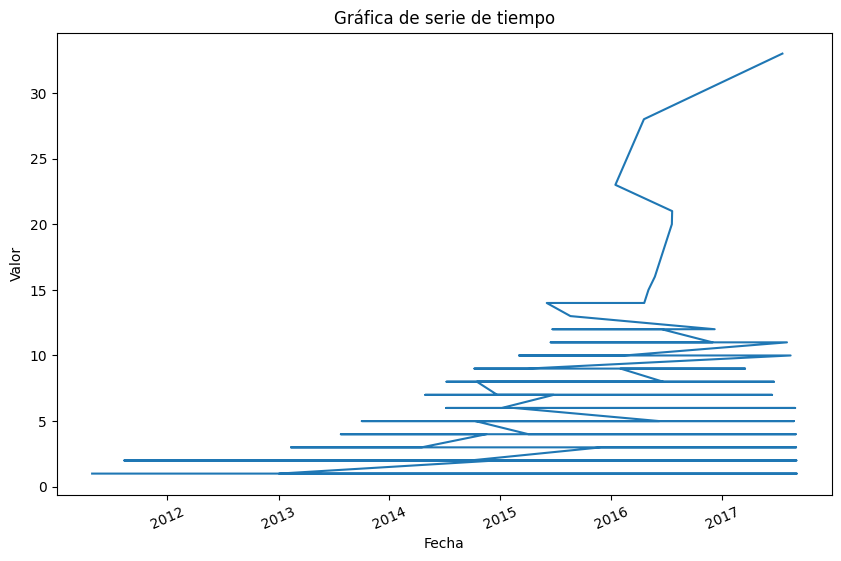

In [154]:

# Convertir el diccionario a una lista de tuplas (timestamp, valor)
data_tuples = [(int(timestamp), value) for timestamp, value in dict(p1["unixReviewTime"].value_counts()).items()]

# Crear un DataFrame a partir de la lista de tuplas
df = pd.DataFrame(data_tuples, columns=['unix_timestamp', 'value'])

# Función para plotear la gráfica de tiempo
def plot_unix_time(df, timestamp_column):
    df['Datetime'] = pd.to_datetime(df[timestamp_column], unit='s')
    df.set_index('Datetime', inplace=True)

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['value'])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Gráfica de serie de tiempo')
    plt.xticks(rotation=24)
    plt.show()

# Utilizar la función para plotear la gráfica de tiempo
plot_unix_time(df, 'unix_timestamp')